## Packages

In [1]:
!pip install pdfplumber PyPDF2
! pip install transformers
import datetime
!pip install sentencepiece accelerate
from transformers import T5Tokenizer, T5ForConditionalGeneration

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


c:\Users\92945\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
import requests
from io import BytesIO
import os
import pdfplumber
import re
from urllib.parse import unquote
from tqdm import tqdm
import io
from PyPDF2 import PdfReader
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
palette = ['#00bfff',  # Deep Sky Blue  
           '#87ceeb',  # Light Blue  
           '#40e0d0',  # Turquoise  
           '#20b2aa']  # Light Sea Green
sns.set_theme(style="white",font_scale = 1.2)
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## 1. Extract and Process PDF Files

This code extracts and processes PDF files.

In [3]:
def create_df_from_txt_file(txt_file_path):
    def extract_year(url):
        pattern = r'(19[0-9]{2}|20[0-9]{2})'
        matches = re.findall(pattern, url)
        return matches[0] if matches else None
    url = txt_file_path
    data = []
    year = extract_year(url)
    data.append({'URL': url, 'Year': year})

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df

In [4]:
def pdf_to_text(file_path):
    try:
        with open(file_path, 'rb') as file:
            reader = PdfReader(file)
            text = ''
            for i in range(len(reader.pages)):
                text += reader.pages[i].extract_text()
        return re.sub(r'\s+', ' ', text).strip()
    except Exception as e:
        return ''
def extract_sentences_from_pdf(url):
    sentences = []
    # Extract text using the pdf_to_text function
    text = pdf_to_text(url)
    # split to senteces by: . ! ? \n
    sentences.extend(re.split(r'[.!?]\s+|\n', text))
    return sentences

def process_df(df):
    # Use tqdm to create a progress bar for the PDF processing
    tqdm.pandas(desc="Processing PDF files")
    # Apply the extract_sentences_from_pdf function to each URL in the 'url' column
    df['sentences'] = df['URL'].progress_apply(extract_sentences_from_pdf)
    return df

In [5]:
def clean_partial_processed_data(file_path: str) -> pd.DataFrame:

    """
    Processes a CSV file containing company data and category classifications.
    """

    # Load the csv file into a DataFrame
    data = pd.read_csv(file_path)

    # Identify rows with unique URLs that start with 'https://'
    company_indicator_rows = data['URL']

    # Extract company data (URL, Company Name, and Year)
    company_data = data[company_indicator_rows][['URL', 'Year']]

    # Extract category data from rows below the company rows
    category_data_rows = data.iloc[company_data.index[-1]+1:]
    category_data_cleaned = category_data_rows.dropna(subset=['category_1', 'category_2', 'category_3', 'category_4', 'category_5'])

    # Reset indices for proper alignment
    company_data = company_data.reset_index(drop=True)
    category_data_cleaned = category_data_cleaned.reset_index(drop=True)

    # Merge the two dataframes
    final_data = pd.concat([company_data, category_data_cleaned[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']]], axis=1)
    final_data.drop(['URL'],axis=1,inplace=True)
    final_data.dropna(inplace=True)
    final_data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'Year']] = final_data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'Year']].astype(int)
    return final_data


In [6]:
txt_file_path = '../A_Group/final_summary/NFLX_2021.pdf'
df = create_df_from_txt_file(txt_file_path)
df

,URL,Year
0,../A_Group/final_summary/NFLX_2021.pdf,2021


In [7]:
# create senteces of each df
full_processed_df = process_df(df)
full_processed_df

Processing PDF files: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


,URL,Year,sentences
0,../A_Group/final_summary/NFLX_2021.pdf,2021,[Environmental Social Governance Report 2021 S...


In [8]:
# Save to CSV
full_processed_output_path = '../A_Group/final_summary/'+txt_file_path.replace('.pdf','.csv').split('/')[-1]
full_processed_df.to_csv(full_processed_output_path, index=False)

##2.  Distributions

Present the distribution of years, companies, and senteces

In [37]:
# load the df
df = pd.read_csv(full_processed_output_path)

# Convert Year column to int
df['Year'] = df['Year'].astype(int)
df = df[['Year','sentences']]

# split to senteces
def split_into_sentences(text):
    return [sentence.strip() for sentence in text.split('\',')]

df['sentences'] = df['sentences'].apply(split_into_sentences)
# Remove the leading ' and trailing " characters from each sentence in the list
df['sentences'] = [
    [sentence.strip("'").strip('"') for sentence in sentence_list]
    for sentence_list in df['sentences']
]

# count number of senteces in each PDF
df['sentence_count'] = df['sentences'].apply(len)
df

,Year,sentences,sentence_count
0,2021,[['Environmental Social Governance Report 2021...,375


In [10]:
# Calculate statistics
statistics = {
    'Number of Sentences': {
        'Average': np.mean(df['sentence_count']),
        'Median': np.median(df['sentence_count']),
        'Standard Deviation': np.std(df['sentence_count']),
        'Max': int(np.max(df['sentence_count'])),
        'Min': int(np.min(df['sentence_count']))
    },
    'Year': {
        'Mode': df['Year'].mode().values[0],
        'Median': np.nan,
        'Standard Deviation': np.std(df['Year']),
       'Max': int(np.max(df['Year'])),
        'Min': int(np.min(df['Year']))
    }
}

# Create a DataFrame to display the statistics
statistics_df = pd.DataFrame(statistics)

# Display the table
statistics_df

,Number of Sentences,Year
Average,375.0,NaN
Median,375.0,NaN
Standard Deviation,0.0,0.0
Max,375.0,2021.0
Min,375.0,2021.0
Mode,NaN,2021.0


## 3. Apply the model

In [38]:
df = pd.read_csv(full_processed_output_path)
df['Year'] = df['Year'].astype(int)  # Convert 'Year' column to integer

def split_into_sentences(text):
    return [sentence.strip() for sentence in text.split('\',')]

df['sentences'] = df['sentences'].apply(split_into_sentences)
# Remove the leading ' and trailing " characters from each sentence in the list
df['sentences'] = [
    [sentence.strip("'").strip('"') for sentence in sentence_list]
    for sentence_list in df['sentences']
]
df

,URL,Year,sentences
0,../A_Group/final_summary/NFLX_2021.pdf,2021,[['Environmental Social Governance Report 2021...


Import model

In [12]:
%pip install sentencepiece
from transformers import T5Tokenizer, T5ForConditionalGeneration

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [13]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

c:\Users\92945\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\92945\.cache\huggingface\hub\models--google--flan-t5-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization

Create prompt and define df to store the model

In [14]:
def detect_category(sentence):
    input_text = "Act as an expert ESG analyst.\n" \
                 "You will be provided a sentence related to a company's environmental, social, and governance (ESG) practices and performance. Your task is to classify each sentence into one of the following five categories:\n" \
                 "[1] Quantitative Evidence: The sentence contains specific numerical or percentage data demonstrating actions the company has already taken to improve its ESG measures. The sentence is primarily in past or present tense.\n" \
                 "[2] Action Evidence: The sentence contains concrete evidence, but no numbers/percentages, showing actions the company has already taken to improve ESG. The sentence is primarily in past or present tense.\n" \
                 "[3] Suggestive Evidence: The sentence suggests, but does not directly state, that the company has already taken actions to improve ESG. It does not contain concrete evidence. The sentence is primarily in past or present tense.\n" \
                 "[4] Future Plan: The sentence discusses the company's plans or intentions to take future ESG actions, but does not provide any evidence of current or past actions. The sentence is primarily in future tense.\n" \
                 "[5] Other: The sentence does not fit any of the above categories.\n"\
                 "For each sentence in the text file, return a number 1-5 indicating which category it belongs to.\n"\
                 f"Sentece: {sentence}"
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids
    outputs = model.generate(input_ids)
    output_text = tokenizer.decode(outputs[0])
    # Extract number from the output text using regex
    extracted_number = re.search(r'\d+', output_text)
    if extracted_number:
        return int(extracted_number.group())
    return None

processed_df = df.copy().reset_index()

# Initialize category columns in processed_df
for i in range(1, 6):
    processed_df[f'category_{i}'] = 0
processed_df

# Create df to store the results
processed_df = processed_df[['URL','Year','sentences','category_1','category_2','category_3','category_4','category_5']]
processed_df.head()

,URL,Year,sentences,category_1,category_2,category_3,category_4,category_5
0,../A_Group/final_summary/NFLX_2021.pdf,2021,[['Environmental Social Governance Report 2021...,0,0,0,0,0


In [ ]:
# Run the model on each sentence

for index, row in enumerate(processed_df.iterrows()):
    # Get the current timestamp
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Display message with timestamp for the PDF being processed
    print(f"\r[{current_time}] Processing PDF {index + 5}", end='', flush=True)

    _, row_data = row
    sentences_categories = []
    category_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

    for sentence_num, sentence in enumerate(row_data['sentences']):
        # Display message with timestamp for the sentence being processed
        print(f"\r[{current_time}] Processing sentence {sentence_num + 1} in PDF {index + 5}", end='', flush=True)

        if len(sentence) < 5:
            continue

        category = detect_category(sentence)

        if category is None:
            print(f'\r[{current_time}] Skipped sentence due to error', end='', flush=True)
            continue

        sentences_categories.append(category)
        category_counts[category] += 1

    for i in range(1, 6):
        processed_df.at[index, f'category_{i}'] = category_counts[i]
        print(f"\nSaved partially processed DataFrame to {partial_output_csv}")


# Print the processed DataFrame
print("\nProcessed DataFrame:")
print(processed_df)

[2024-11-12 23:17:40] Processing sentence 1 in PDF 5

c:\Users\92945\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[2024-11-12 23:17:40] Processing sentence 375 in PDF 5
Saved partially processed DataFrame to ../A_Group/final_summary/partial_processed_data.csv

Saved partially processed DataFrame to ../A_Group/final_summary/partial_processed_data.csv

Saved partially processed DataFrame to ../A_Group/final_summary/partial_processed_data.csv

Saved partially processed DataFrame to ../A_Group/final_summary/partial_processed_data.csv

Saved partially processed DataFrame to ../A_Group/final_summary/partial_processed_data.csv

Processed DataFrame:
                                      URL  Year  \
0  ../A_Group/final_summary/NFLX_2021.pdf  2021   

                                           sentences  category_1  category_2  \
0  [['Environmental Social Governance Report 2021...          55          18   

   category_3  category_4  category_5  
0         136          45         114  


In [20]:
processed_df

,URL,Year,sentences,category_1,category_2,category_3,category_4,category_5
0,../A_Group/final_summary/NFLX_2021.pdf,2021,[['Environmental Social Governance Report 2021...,55,18,136,45,114


## 4. Results & Stataitics
Comparisons a company in different years

In [21]:
df = processed_df[['Year', 'category_1', 'category_2','category_3', 'category_4', 'category_5']]
df.head()

,Year,category_1,category_2,category_3,category_4,category_5
0,2021,55,18,136,45,114


### Mean Precentage of each Category (1-4)

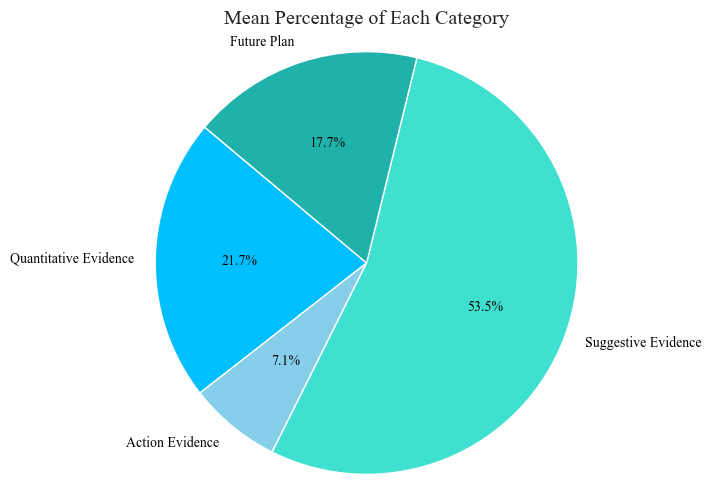

In [33]:
categories = ['category_1', 'category_2', 'category_3', 'category_4']
category_labels = [
    "Quantitative Evidence",
    "Action Evidence",
    "Suggestive Evidence",
    "Future Plan",
]

# Calculate the mean percentage for each category
mean_percentages = []
for category in categories:
    mean_percentage = df[category].mean()
    mean_percentages.append(mean_percentage)

# Create a pie plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    mean_percentages,
    labels=category_labels,
    autopct='%.1f%%',
    startangle=140,
    colors=palette,
    textprops=dict(color="black")
)

# Add category labels to the center of each wedge
for text, autotext in zip(texts, autotexts):
    text.set(size=10)
    autotext.set(size=10)

# Set title and aspect ratio
plt.title('Mean Percentage of Each Category')
plt.axis('equal')

# Show the plot
plt.show()

In [63]:
import os
import re
import nltk
import pandas as pd
nltk.download('punkt')

if not os.path.exists("pdf_text"):
    os.makedirs("pdf_text")

import unicodedata
def remove_non_english_chars(text):
    # normalize text and check if ASCII value more than 128 (non-english words)
    return ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn' and
                   ord(c) < 128)

output_filename = full_processed_output_path


# read the text file
with open(output_filename, 'r', encoding='utf-8') as f:
        text = f.read()

# clean the data
text = remove_non_english_chars(text)
text = re.sub(r'\n', ' ', text)  # remove line breaks
text = re.sub(r'\s+', ' ', text)  # remove multiple spaces
sentences = nltk.sent_tokenize(text) # split the text into sentences
processed_sentences = []
for sentence in sentences:
    sentence = re.sub(r"\d+\n", "", sentence) # Remove page number
    sentence = re.sub(r"\n", " ", sentence) # Remove line breaks
    sentence = re.sub(r"\.(\s*\.){1,}", ". ", sentence) # Remove consecutive periods
    split_sentences = re.split("(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)(?<!\d\.)\s*(?=[A-Z])", sentence) # split text into sentences

    split_sentences = [s for s in split_sentences if s != "" and s != "."] # do not include empty sentences or "."
    processed_sentences.extend(split_sentences)

    # create a dataframe
df = pd.DataFrame({'sentences': processed_sentences})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\92945\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### ESG-BERT
- Domain Specific BERT Model for Text Mining in Sustainable Investing
- URL: https://huggingface.co/nbroad/ESG-BERT
- This pre-trained model is able to classify each text and returns a label number which correlates to a textual label:
    * __label__Business_Ethics :  0
    * __label__Data_Security :  1
    * __label__Access_And_Affordability :  2
    * __label__Business_Model_Resilience :  3
    * __label__Competitive_Behavior :  4
    * __label__Critical_Incident_Risk_Management :  5
    * __label__Customer_Welfare :  6
    * __label__Director_Removal :  7
    * __label__Employee_Engagement_Inclusion_And_Diversity :  8
    * __label__Employee_Health_And_Safety :  9
    * __label__Human_Rights_And_Community_Relations :  10
    * __label__Labor_Practices :  11
    * __label__Management_Of_Legal_And_Regulatory_Framework :  12
    * __label__Physical_Impacts_Of_Climate_Change :  13
    * __label__Product_Quality_And_Safety :  14
    * __label__Product_Design_And_Lifecycle_Management :  15
    * __label__Selling_Practices_And_Product_Labeling :  16
    * __label__Supply_Chain_Management :  17
    * __label__Systemic_Risk_Management :  18
    * __label__Waste_And_Hazardous_Materials_Management :  19
    * __label__Water_And_Wastewater_Management :  20
    * __label__Air_Quality :  21
    * __label__Customer_Privacy :  22
    * __label__Ecological_Impacts :  23
    * __label__Energy_Management :  24
    * __label__GHG_Emissions :  25


In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math

tokenizer = AutoTokenizer.from_pretrained("nbroad/ESG-BERT")
model = AutoModelForSequenceClassification.from_pretrained("nbroad/ESG-BERT")

### Step 1: Mapping ESG-BERT's topics to SGX and S&P ESG Criteria Topics
1. Using ESG-BERT to classify our SGX and S&P Global ESG Criteria Topics into its labels
2. We only take the predict label with highest probability.
3. For those labels without any SGX and S&P ESG Criteria Topics, we will manually map them ourselves based on relevancy

`labels_to_criteria`
- Key: ESG-BERT's ESG_Labels
- Value: SGX and S&P Global ESG Criteria Topics

In [45]:
import pandas as pd
import numpy as np
labels_to_criteria = {}
manual_mapping = []

# Criteria_Topics is a concatenated list of criteria topics from the industries that we are analyzing
with open("C:/Users/92945/Desktop/A_Group/final_summary/Scrapers/criteria_topics.txt", "r") as f:
    criteria_topics = eval(f.read())

for topic in criteria_topics:
    inputs = tokenizer(topic, return_tensors="pt")
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    top_probs, top_labels = torch.topk(probs, k=1)
    label = model.config.id2label[top_labels[0][0].item()]
    prob = top_probs[0][0].item()

    if label not in labels_to_criteria:
        labels_to_criteria[label] = []
    labels_to_criteria[label].append(topic)

# KEY: ESG-BERT's ESG_Labels
# Value: List of S&P Global ESG Criteria Topics
labels_to_criteria

{'Physical_Impacts_Of_Climate_Change': ['Climate Strategy'],
 'Business_Model_Resilience': ['Human Capital Development',
  'Innovation Management'],
 'Human_Rights_And_Community_Relations': ['Human Rights',
  'Environmental Policy & Management Systems',
  'Social Impacts on Communities',
  'Stakeholder Engagement'],
 'Data_Security': ['Information Security Cybersecurity & System Availability',
  'Network Reliability'],
 'Energy_Management': ['Operational Eco-Efficiency',
  'Low Carbon Strategy',
  'Energy Mix',
  'Electricity Generation',
  'Fuel Efficiency'],
 'Product_Design_And_Lifecycle_Management': ['Product Stewardship',
  'Packaging',
  'Sustainable Marketing & Brand Perception',
  'Sustainable Finance',
  'Circular Fashion'],
 'Supply_Chain_Management': ['Supply Chain Management'],
 'Employee_Engagement_Inclusion_And_Diversity': ['Talent Attraction & Retention',
  'Financial Inclusion'],
 'Labor_Practices': ['Labor Practice Indicators'],
 'Systemic_Risk_Management': ['Risk & Cr

In [46]:
labels_to_criteria = {
    'Physical_Impacts_Of_Climate_Change':['Climate Strategy'],
    'Board Composition': ['Women On The Board'],
    'Economic Performance': ['Total Assets', 'Net Profit'],
    'Business_Model_Resilience': ['Human Capital Development', 'Innovation Management'],
    'Human_Rights_And_Community_Relations': ['Human Rights', 'Environmental Policy & Management Systems', 'Social Impacts on Communities', 'Stakeholder Engagement','Employees Gender & Age Diversity'],
    'Data_Security': ['Information Security Cybersecurity & System Availability', 'Network Reliability'],
    'Energy_Management': ['Operational Eco-Efficiency', 'Low Carbon Strategy', 'Energy Mix', 'Electricity Generation', 'Fuel Efficiency', 'Water Related Risks'],
    'Product_Design_And_Lifecycle_Management': ['Product Stewardship', 'Packaging', 'Sustainable Marketing & Brand Perception', 'Sustainable Finance', 'Circular Fashion'],
    'Supply_Chain_Management': ['Supply Chain Management'],
    'Employee_Engagement_Inclusion_And_Diversity': ['Talent Attraction & Retention', 'Financial Inclusion'],
    'Labor_Practices': ['Labor Practice Indicators','Average Training Hours Per Employee'],
    'Systemic_Risk_Management': ['Risk & Crisis Management', 'Decarbonization Strategy'],
    'Product_Quality_And_Safety': ['Product Quality & Recall Management'],
    'Management_Of_Legal_And_Regulatory_Framework': ['Responsibility of Content', 'Compliance with Applicable Export Control Regimes'],
    'Competitive_Behavior': ['Corporate Governance', 'Market Opportunities'],
    'Employee_Health_And_Safety': ['Occupational Health & Safety', 'Health Outcome Contribution'],
    'Access_And_Affordability': ['Access to Healthcare'],
    'Business_Ethics': ['Business Ethics'],
    'Ecological_Impacts': ['Biodiversity', 'Sustainable Agricultural Practices'],
    'Waste_And_Hazardous_Materials_Management': ['Food Loss & Waste', 'Waste Generation'],
    'Water_And_Wastewater_Management': ['Water Related Risks'],
    'ESG_Certificates': ['List of ESG Certifications'],
    "Air_Quality": ['Low Carbon Strategy'], # manual mapping
    "Critical_Incident_Risk_Management": ['Risk & Crisis Management'], # manual mapping
    "Customer_Privacy": ['Information Security Cybersecurity & System Availability'], # manual mapping
    "Customer_Welfare": ['Social Impacts on Communities', 'Human Rights', 'Stakeholder Engagement'], # manual mapping
    "Director_Removal": ['Business Ethics'], # manual mapping
    "GHG_Emissions": ['Operational Eco-Efficiency', 'Green House Gas Emissions', 'Decarbonization Strategy', 'GHG_Emissions'], # manual mapping
    "Selling_Practices_And_Product_Labeling": ['Business Ethics', 'Product Stewardship', 'Packaging', 'Sustainable Marketing & Brand Perception'], # manual mapping
}

### Step 2: Preparing all the mappings collected from webscrapping

Import Industry to Criteria Topics Mapping as `industry_criteria_mapping`
- Key: Industry
- Value: List of most relevant criteria topics

In [48]:
industry_criteria_df = pd.read_csv("C:/Users/92945/Desktop/A_Group/final_summary/Scrapers/Industry Criteria Topics.csv").transpose()
industry_criteria_mapping = {}

for industry, topics in industry_criteria_df.iterrows():
    if industry not in industry_criteria_mapping:
        industry_criteria_mapping[industry] = []
    topics = topics.dropna()
    industry_criteria_mapping[industry].extend(topics.to_list())
industry_criteria_mapping

{'Industry: New Energy': ['Climate Strategy',
  'Human Capital Development',
  'Human Rights',
  'Operational Eco-Efficiency',
  'Innovation Management',
  'Environmental Policy & Management Systems',
  'Women On The Board',
  'Supply Chain Management',
  'Water Related Risks',
  'Low Carbon Strategy',
  'Corporate Governance',
  'Business Ethics',
  'Occupational Health & Safety',
  'Labor Practice Indicators',
  'Waste Generation',
  'Green House Gas Emissions',
  'Employees Gender & Age Diversity',
  'Average Training Hours Per Employee',
  'List of ESG Certifications',
  'Economic Performance',
  'Total Assets',
  'Net Profit']}

### Step 3: Run report into ESG-BERT model to classify each sentence

In [49]:
import torch
import math

def run_model(input_file, model):
    counter = 1
    max_seq_length = tokenizer.model_max_length
    # with open(input_file, "r") as f:
    input_df = input_file
    output = {}
    for line in input_df['sentences']:
        if len(line) <= max_seq_length:
            output['Line ' + str(counter)] = {}
            inputs = tokenizer(line, return_tensors="pt")
            outputs = model(**inputs)
            probs = outputs.logits.softmax(dim=1)

            # Extract the top 3 probabilities and labels
            top_probs, top_labels = torch.topk(probs, k=3)
            # store output
            output['Line ' + str(counter)]['Sentence'] = line
            for i in range(3):
                label = model.config.id2label[top_labels[0][i].item()]
                prob = top_probs[0][i].item()
                output['Line ' + str(counter)][f'ESG BERT Topic {i+1}'] = (label, prob)
            counter += 1
        else:
            # split input text into chunks
            text_chunks = []
            for i in range(math.ceil(len(line)/max_seq_length)):
                start = i * max_seq_length
                end = min((i+1)*max_seq_length, len(line))
                text_chunks.append(line[start:end])
            for chunk in text_chunks:
                output['Line ' + str(counter)] = {}
                inputs = tokenizer(chunk, return_tensors="pt", padding= True, truncation=True, max_length=max_seq_length)
                outputs = model(**inputs)
                probs = outputs.logits.softmax(dim=1)
                top_probs, top_labels = torch.topk(probs, k=3)

                output['Line ' + str(counter)]['Sentence'] = line
                for i in range(3):
                    label = model.config.id2label[top_labels[0][i].item()]
                    prob = top_probs[0][i].item()
                    output['Line ' + str(counter)][f'ESG BERT Topic {i+1}'] = (label, prob)
                counter += 1
    return output

### Step 4: Mapping output labels to our criteria topics
- We will map the output labels generated by ESG-BERT with the mapping, `mapped_to_criteria`
- We also have decided to classify sentences whose label with the highest probability is less than 0.50 as `Non-ESG`

In [50]:
''' [How it works]
    1. Get the list of most relevant criteria topics for the company based on its industry
    2. Based on the ESG_label with the highest probability, we get the list of potential criteria topics that can be mapped to the target ESG_label
    3. We check the list of potential criteria topics using the list of most relevant criteria topics
    4. If it exists, we just map the label to that criteria topic.
'''
def process_output(result, industry_criteria_mapping):
    # 将行业硬编码为“新能源”
    industry = "Industry: New Energy"

    # 初始化 DataFrame
    df = pd.DataFrame.from_dict(result, orient='index')

    # 获取“新能源”行业的相关 ESG 主题列表
    industry_criteria_topics = industry_criteria_mapping[industry]

    def mapperFunction(row, industry_criteria_topics):
        value = row[1]
        if value < 0.5:
            return ("NON-ESG", value)
        else:
            # 获取当前 ESG 标签的潜在映射主题
            mapped_criteria_topics = labels_to_criteria[row[0]]
            result = []
            # 检查是否符合“新能源”行业标准主题
            for topic in mapped_criteria_topics:
                if topic in industry_criteria_topics:
                    result.append(topic)
            return (result, value)
    df['Mapped Criteria Topic 1'] = df['ESG BERT Topic 1'].apply(lambda x: mapperFunction(x,industry_criteria_topics))
    df['Mapped Criteria Topic 2'] = df['ESG BERT Topic 2'].apply(lambda x: mapperFunction(x,industry_criteria_topics))
    df['Mapped Criteria Topic 3'] = df['ESG BERT Topic 3'].apply(lambda x: mapperFunction(x,industry_criteria_topics))
    return df

In [60]:
def export_output_to_csv(df, output_filename):
    df.to_csv(output_filename)

In [64]:
import os
import pandas as pd

'''
Note: This will take about 2 hours to classify all 25 ESG reports.

For a sample output please run the code chunk below
'''
input_file = df
output_file = "C:/Users/92945/Desktop/A_Group/final_summary/classified_sentences/"+txt_file_path.replace('pdf','csv').split("/")[-1]

output_result = run_model(input_file, model)

In [65]:
output_df = process_output(output_result, industry_criteria_mapping)

######## SAMPLE OUTPUT RUN THIS ########
# filename = "AMZN_2021.csv"
# ticker = filename.split("_")[0]
# industry = company_industry_mapping[ticker]
# input_file = "pdf_text" + "/" + filename
# ouptut_file = "output/classified_sentences/" + filename.replace(".csv", "_results.csv")
# output_result = run_model(input_file, model)
# output_df = process_output(output_result, industry_criteria_mapping, industry)
# export_output_to_csv(output_df, output_file)

In [55]:
!pip install torch
!pip install transformers
!pip install evaluate
!pip install pickle

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [66]:
import transformers
import pandas as pd
import os
from collections import defaultdict
import re
from ast import literal_eval
topics_by_company = {}
reports = {}
df = pd.read_csv(output_file)
ticker = output_file.split('/')[-1].split('_')[0]
reports[ticker] = df

for company, data in reports.items():
    topics_by_company[company] = {}
    for index, row in data.iterrows():
        mapped_criteria_topic_1 = literal_eval(row['Mapped Criteria Topic 1'])
        mapped_criteria_topic_2 = literal_eval(row['Mapped Criteria Topic 2'])
        mapped_criteria_topic_3 = literal_eval(row['Mapped Criteria Topic 3'])
        sentence = row['Sentence']
        if mapped_criteria_topic_1[0] != 'NON-ESG':
            if mapped_criteria_topic_1[0] != []:
                for i in  mapped_criteria_topic_1[0]:
                    if i not in topics_by_company[company]:
                        topics_by_company[company][i] = {}
                    topics_by_company[company][i][sentence] = mapped_criteria_topic_1[1]
            else:
                if mapped_criteria_topic_2[0] != 'NON-ESG':
                    if mapped_criteria_topic_2[0] != []:
                        for i in  mapped_criteria_topic_2[0]:
                            if i not in topics_by_company[company]:
                                topics_by_company[company][i] = {}
                            topics_by_company[company][i][sentence] = mapped_criteria_topic_2[1]
                    else:
                        if mapped_criteria_topic_3[0] != 'NON-ESG':
                            if mapped_criteria_topic_3[0] != []:
                                for i in  mapped_criteria_topic_3[0]:
                                    if i not in topics_by_company[company]:
                                        topics_by_company[company][i] = {}
                                    topics_by_company[company][i][sentence] = mapped_criteria_topic_3[1]

In [67]:
# Sort sentences by topic according to probability
for company, data in topics_by_company.items():
    for topic, sentence_prob in data.items():
        sorted_sentence_prob = dict(sorted(sentence_prob.items(), key = lambda x: x[1], reverse=True))
        topics_by_company[company][topic] = sorted_sentence_prob

In [68]:
company_topic_sentences = {}
for company, data in topics_by_company.items():
    company_topic_sentences[company] = {}
    for topic, sentences in data.items():
        if topic not in company_topic_sentences[company]:
            company_topic_sentences[company][topic] = []
        for sentence, prob in sentences.items():
            company_topic_sentences[company][topic].append(sentence)

In [69]:
from transformers import pipeline
import nltk
from nltk.tokenize import sent_tokenize

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Helper function to split the text into segments
def split_in_segments(text):
    tokens = 0
    mystring = list()
    segments = []
    text = re.sub(r'(?<=\w)(\.)', r' \1', text)
    for sent in sent_tokenize(text):
        newtokens = len(sent.split())
        if tokens + newtokens > 500:
            segments.append(" ".join(mystring))
            mystring = []
            mystring.append(str(sent).strip())
            tokens = newtokens
        elif newtokens > 500:
            segments.extend([str(sent)[i:i+500] for i in range(0, len(str(sent)), 500)])
        else:
            tokens += newtokens
            mystring.append(str(sent).strip())

    if mystring:
        segments.append(" ".join(mystring))

    return segments


In [70]:
def summarize_text(input_text):
    segments = split_in_segments(input_text)
    summaries = []
    
    # Define maximum token limit for the model (e.g., 512 for BERT-based models)
    max_tokens = 512
    
    for seg in segments:
        # Check if the segment is too long
        tokens = tokenizer.encode(seg, truncation=False)  # Encode without truncating
        if len(tokens) > max_tokens:
            # Truncate the segment to max tokens if too long
            seg = tokenizer.decode(tokens[:max_tokens], skip_special_tokens=True)
        
        try:
            # Generate summary for the segment
            summary = summarizer(seg, truncation=True, max_length=100, min_length=30, do_sample=False)
            summaries.extend(summary)
        except IndexError as e:
            print(f"IndexError for segment: {seg[:50]}...")  # Log the beginning of the problematic segment
            continue  # Skip to the next segment if there's an error

    return summaries

In [71]:
company_summary_sentences = {}

for company, data in company_topic_sentences.items():
    print(f"Summarizing {company}")
    output = {}

    for topic, sentences in data.items():
        print(f"### Topic: {topic} ###")

        input_sentences = " ".join(sentences[:20]) # Top 20 sentences
        reference_summary = sentences[:40] # reference summary don't change
        summary_list = summarize_text(input_sentences)
        combined_summary = summary_list[0]['summary_text']
        for summary in summary_list[1:]:
            combined_summary += summary['summary_text']
        output[topic] = (combined_summary, " ".join(reference_summary))
    if company not in company_summary_sentences:
        company_summary_sentences[company] = {}
    company_summary_sentences[company] = output


Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Summarizing NFLX
### Topic: Human Rights ###


Your max_length is set to 100, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


### Topic: Environmental Policy & Management Systems ###


Your max_length is set to 100, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


### Topic: Employees Gender & Age Diversity ###


Your max_length is set to 100, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


### Topic: Operational Eco-Efficiency ###


Your max_length is set to 100, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


### Topic: Low Carbon Strategy ###


Your max_length is set to 100, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


### Topic: Water Related Risks ###


Your max_length is set to 100, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


### Topic: Climate Strategy ###


Your max_length is set to 100, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 100, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


### Topic: Green House Gas Emissions ###


Your max_length is set to 100, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


### Topic: Corporate Governance ###


Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


### Topic: Labor Practice Indicators ###


Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


### Topic: Average Training Hours Per Employee ###


Your max_length is set to 100, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


### Topic: Business Ethics ###


In [80]:
output_df = pd.DataFrame.from_dict(output, orient='index')
output_df = output_df.rename_axis("topic").reset_index()
output_df.rename(columns={0: "combined_summary", 1: "reference_summary"}, inplace=True)
top_20_summaries_path = f"C:/Users/92945/Desktop/A_Group/final_summary/Generated Summaries/{company}_top20_summaries.csv"
output_df.to_csv(top_20_summaries_path)

In [73]:
# Helper Function to compute ROUGE-N scores from Huggingface's evaluate library
%pip install evaluate
import evaluate
def evaluateRouge(output):
    output_results = {}
    rouge = evaluate.load('rouge')
    for idx, row in output.iterrows():
        topic = row[0]
        generated = [row[1]]
        reference = [row[2]]
        results = rouge.compute(predictions=generated, references = reference)
        output_results[topic] = results
    return output_results

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [74]:
# Helper Function to calculate the average ROUGE-N score
def averageEvaluation(results):
    output_dict = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
        'rougeLsum': 0
    }
    for topic, rougeData in results.items():
        output_dict['rouge1'] = sum(val['rouge1'] for val in results.values())/len(results)
        output_dict['rouge2'] = sum(val['rouge2'] for val in results.values())/len(results)
        output_dict['rougeL'] = sum(val['rougeL'] for val in results.values())/len(results)
        output_dict['rougeLsum'] = sum(val['rougeLsum'] for val in results.values())/len(results)
    return output_dict

In [76]:
# For each company, compute average ROUGE-N scores across all generated summaries
import os
%pip install rouge_score
generated_summaries_path = "C:/Users/92945/Desktop/A_Group/final_summary/Generated Summaries/"

evaluation_results = {}

for filename in os.listdir(generated_summaries_path):
    summaries = pd.read_csv(generated_summaries_path + filename)
    summaries_result = evaluateRouge(summaries)
    company = filename.split("_")[0]
    input_type = filename.split("_")[1]
    if input_type not in evaluation_results:
        evaluation_results[input_type] = {}
    evaluation_results[input_type][company] = averageEvaluation(summaries_result)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [77]:
# Save evaluation data as pickle file to reopen for review
import pickle

save_file = True # Set as true if you want to save the evaluation_results dictionary as pickle file

if save_file: # save evaluation results as pickle file
    file_to_save = open('Evaluation_Result', 'ab')
    pickle.dump(evaluation_results, file_to_save)
    file_to_save.close()
else: # Set as false to open the file
    saved_file = open('Evaluation_Result', 'rb')
    evaluation_results = pickle.load(saved_file)

In [78]:
# Calculate Average ROUGE-N scores across types of inputs (Top20/Top30/Random20/Random30)
show_evaluation = {}
for k,v in evaluation_results.items():
    show_evaluation[k] = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
        'rougeLsum': 0
    }

    show_evaluation[k]['rouge1'] = sum(val['rouge1'] for val in v.values())/len(v)
    show_evaluation[k]['rouge2'] = sum(val['rouge2'] for val in v.values())/len(v)
    show_evaluation[k]['rougeL'] = sum(val['rougeL'] for val in v.values())/len(v)
    show_evaluation[k]['rougeLsum'] = sum(val['rougeLsum'] for val in v.values())/len(v)

pd.DataFrame.from_dict(show_evaluation, orient='index').sort_index()

,rouge1,rouge2,rougeL,rougeLsum
top20,0.001898,0.0,0.001898,0.001898


In [81]:
import openai
import pandas as pd

# 设置 OpenAI API 密钥
openai.api_key = 'sk-vzRrOeVbcm0RfRvb7k29Sy13PNAqCdChUvmvaDVs4iT3BlbkFJZcMi-v0cfYyqyTzr9xfM0QIk9Lk_8vPkdbCGaHxKUA'

import openai
import pandas as pd

# 读取CSV文件
csv_file_path = top_20_summaries_path
df = pd.read_csv(csv_file_path)

# 定义用于调用 ChatGPT API 的函数
def get_quantitative_summary(text):
    # Use client.chat.completions.create with OpenAI object
    client = openai.OpenAI(api_key='sk-vzRrOeVbcm0RfRvb7k29Sy13PNAqCdChUvmvaDVs4iT3BlbkFJZcMi-v0cfYyqyTzr9xfM0QIk9Lk_8vPkdbCGaHxKUA',) # Create an OpenAI object
    response = client.chat.completions.create(
        model="gpt-3.5-turbo", # Use a suitable chat model, like gpt-3.5-turbo
        messages=[
            {"role": "system", "content": "You are a helpful ESG expert that summarizes a company's ESG report text."},
            {"role": "user", "content": f"Please summarize the following text in 1-2 sentences containing quantitative explanation if available:\n{text}"}
        ],
        temperature=0.3,  # 保持生成内容的稳定性
        max_tokens=500,
        top_p=1.0,       # 使用完整的采样
        frequency_penalty=0,  # 允许适度重复关键信息
        presence_penalty=0
    )
    summary = response.choices[0].message.content # Access the summary text from the response
    return summary.strip()

# 存储每行处理后的量化摘要
summary_sentences = []

# 遍历每行，调用 API 生成量化的1-2句总结
for index, row in df.iterrows():
    topic = row['topic']
    combined_summary = row['combined_summary']

    # 调用 ChatGPT API 生成量化总结
    quantitative_summary = get_quantitative_summary(combined_summary)

    # 将量化总结添加到列表中
    summary_sentences.append(f"{topic}:{quantitative_summary}\n")

# 拼接成完整的公司级摘要
final_summary = " ".join(summary_sentences)

# 打印公司级摘要
print(final_summary)

Human Rights:In 2021, Netflix made significant progress in addressing emissions and integrating sustainability into their core business practices, as per their ESG report referencing SASB's reporting framework for internet & media services. They selected 17 projects for their carbon credit portfolio, with 73% of credits receiving additional certification under Verra's Climate, Community & Biodiversity program. These projects focus on preventing carbon emissions and regenerating natural ecosystems to act as carbon sinks.
 Environmental Policy & Management Systems:In 2021, Netflix made significant progress in addressing emissions and integrating sustainability into its core business practices, following the SASB reporting framework for internet & media services and media & entertainment industries. The company selected 17 projects for its carbon credit portfolio, with 73% of the credits receiving additional certification under Verra's Climate, Community & Biodiversity program. These proj